# **LIBRARIES**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import random
import os

from google.colab import drive

# **MOUNT GOOGLE DRIVE**


In [ ]:
drive.mount('/content/drive', force_remount=True)

SAVE_PATH = "/content/drive/MyDrive/NN_CIFAR10_Project"
print("Drive mounted. Models & outputs will be loaded/saved here:", SAVE_PATH)

Mounted at /content/drive
Drive mounted. Models & outputs will be loaded/saved here: /content/drive/MyDrive/NN_CIFAR10_Project


# **LOAD DATASET**

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


Device: cpu


# **MODEL ARCHITECTURE**

In [ ]:
class BestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.network(x)


class BestCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, 2)

        return self.classifier(x)

# **LOAD MODEL**

In [ ]:
def load_model(model_class, model_name):
    model = model_class().to(device)
    path = f"{SAVE_PATH}/{model_name}_model.pth"

    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    print(f"Loaded model: {model_name}")
    return model

# **Run inference on test set**

In [ ]:
def get_predictions(model, loader):
    all_imgs, all_labels, all_preds = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            _, pred = out.max(1)

            all_imgs.append(x.cpu())
            all_labels.append(y)
            all_preds.append(pred.cpu())

    return (torch.cat(all_imgs),
            torch.cat(all_labels),
            torch.cat(all_preds))

# **CIFAR-10 Un-normalization**

In [ ]:
mean = torch.tensor([0.4914, 0.4822, 0.4465]).reshape(3,1,1)
std = torch.tensor([0.2023, 0.1994, 0.2010]).reshape(3,1,1)

def unnormalize(img):
    return img * std + mean

def imshow(img):
    img = unnormalize(img)
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')

# **Plot correct or incorrect predictions (SVG)**

In [ ]:
def plot_samples(images, labels, preds, class_names,
                 correct=True, num=12, filename="output.svg"):

    idx = (preds == labels).nonzero().squeeze() if correct else (preds != labels).nonzero().squeeze()
    idx = idx.tolist() if isinstance(idx, torch.Tensor) else []

    selected = random.sample(idx, min(num, len(idx)))

    plt.figure(figsize=(14, 8))
    for i, idd in enumerate(selected):
        plt.subplot(3, 4, i+1)
        imshow(images[idd])
        color = "green" if correct else "red"
        plt.title(f"Pred: {class_names[preds[idd]]}\nTrue: {class_names[labels[idd]]}",
                  fontsize=9, color=color)
    title = "Correct Predictions" if correct else "Incorrect Predictions"
    plt.suptitle(title, fontsize=16)

    save_path = f"{SAVE_PATH}/{filename}"
    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

    print("Saved:", save_path)

Loaded model: CNN-Best-150ep


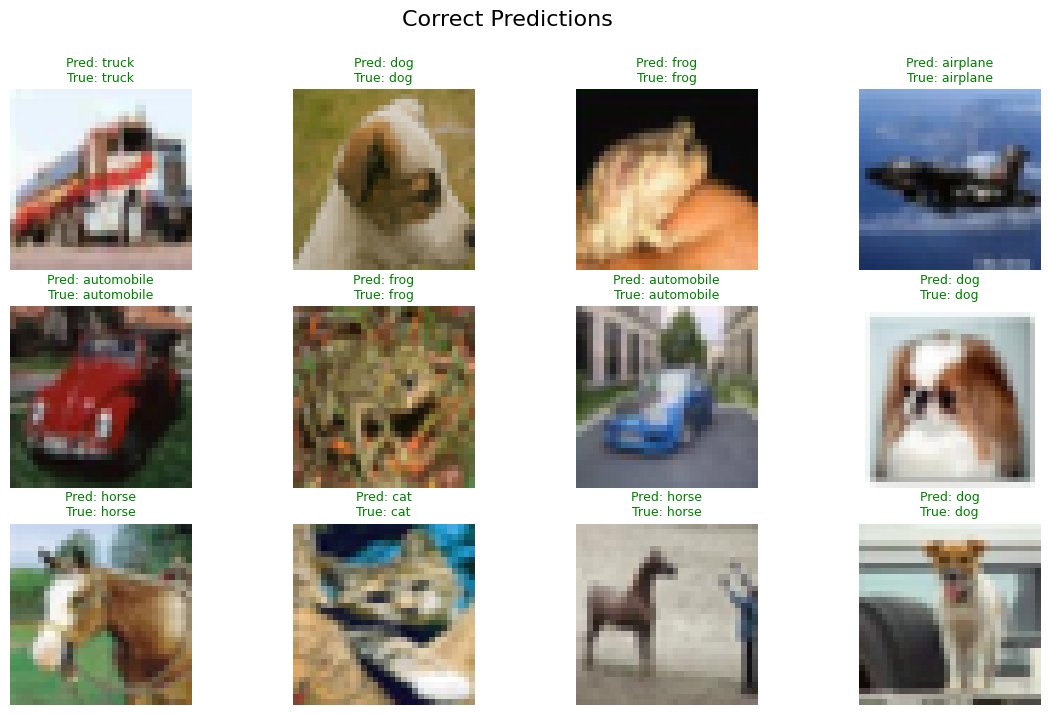

Saved: /content/drive/MyDrive/NN_CIFAR10_Project/CNN-Best-150ep_correct.svg


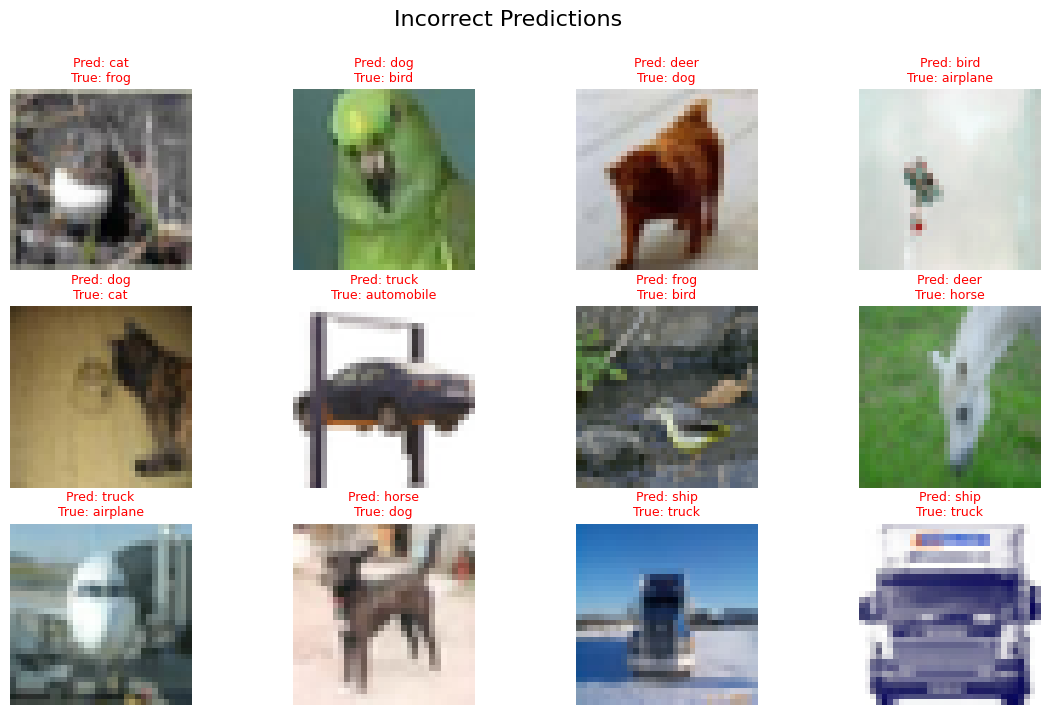

Saved: /content/drive/MyDrive/NN_CIFAR10_Project/CNN-Best-150ep_incorrect.svg


In [ ]:
# ---- Pick a model name from Drive ----
model_name = "CNN-Best-150ep"     # ή "MLP-Best", "CNN-Best-100ep", κ.λπ.

# ---- Pick appropriate model class ----
model_class = BestCNN if "CNN" in model_name else BestMLP

# Load trained model
model = load_model(model_class, model_name)

# Run inference
imgs, labels, preds = get_predictions(model, testloader)

# Plot and save SVGs
plot_samples(imgs, labels, preds, class_names,
             correct=True, filename=f"{model_name}_correct.svg")

plot_samples(imgs, labels, preds, class_names,
             correct=False, filename=f"{model_name}_incorrect.svg")